In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import sqlite3
import matplotlib.pyplot as plt
import warnings
import tensorflow as tf
# Ignore all warnings
warnings.filterwarnings("ignore")

from keras_tuner import RandomSearch
from sklearn.model_selection import train_test_split



In [2]:
# Load data into an SQLite database
conn = sqlite3.connect('crypto_data.db')

# Load CSV files into the database
crypto_files = {
    "Bitcoin": "Bitcoin_data.csv",
    "Dogecoin": "Dogecoin_data.csv",
    "Ethereum": "Ethereum_data.csv",
    "Litecoin": "Litecoin_data.csv",
    "SPY": "SPY_data.csv",
    "XRP": "XRP_data.csv"
}

for name, file in crypto_files.items():
    df = pd.read_csv(file)
    df.to_sql(name, conn, if_exists='replace', index=False)


In [3]:
# Query the data for Bitcoin
query = """
SELECT Date, PX_HIGH, PX_LOW, PX_LAST 
FROM Bitcoin
WHERE PX_HIGH IS NOT NULL AND PX_LOW IS NOT NULL AND PX_LAST IS NOT NULL;
"""
data = pd.read_sql(query, conn)
data



,Date,PX_HIGH,PX_LOW,PX_LAST
0,1/6/2025,102504.01,97935.65,101661.87
1,1/5/2025,98615.09,97268.96,98482.42
2,1/4/2025,98753.86,97557.64,98355.29
3,1/3/2025,98956.93,96036.70,98243.40
4,1/2/2025,97742.11,94184.64,97123.79
...,...,...,...,...
1825,1/5/2020,7464.56,7363.55,7363.55
1826,1/3/2020,7400.72,6859.44,7269.82
1827,1/2/2020,7246.71,6912.96,6960.58
1828,1/1/2020,7236.37,7151.89,7216.21


In [4]:
# Close the connection
conn.close()

In [5]:
# Sort data by most recent dates
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data.sort_index()

In [6]:
# correlation_matrix = data[['PX_HIGH', 'PX_LOW', 'PX_LAST']].corr()
# print(correlation_matrix)

# # Calculate moving averages
# data['MA_5'] = data['PX_LAST'].rolling(window=5).mean()
# data['MA_10'] = data['PX_LAST'].rolling(window=10).mean()

# # Calculate percentage change
# data['Pct_Change'] = data['PX_LAST'].pct_change()

# # Drop NaN values created by rolling calculations
# data.dropna(inplace=True)

# # Select features for LSTM
# features = data[['PX_HIGH', 'PX_LOW', 'MA_5', 'MA_10', 'Pct_Change']]
# target = data['PX_LAST']

In [7]:
# Data Cleaning and Normalization
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data[["PX_LAST", "PX_LOW", "PX_HIGH"]].values)


In [8]:
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

def create_dataset (data, time_step = 60): #sixty days of data to be looked at.
    X, y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i + time_step), :])
        y.append(data[i + time_step, 2])
    return np.array(X), np.array(y)


In [9]:
# time_steps = 10

# X, y = [], []

# for i in range(len(scaled_features) - time_steps):
#     X.append(scaled_features[i:i + time_steps])
#     y.append(target.iloc[i + time_steps])  # Use the target value at the end of the sequence

# X, y = np.array(X), np.array(y)

# # Check the shape of X
# print("Shape of X before splitting:", X.shape)  # Should be (samples, time_steps, features)
# X


In [10]:
# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Display the shapes of the resulting datasets
# print(f"X_train shape: {X_train.shape}")
# print(f"X_test shape: {X_test.shape}")
# print(f"y_train shape: {y_train.shape}")
# print(f"y_test shape: {y_test.shape}")

# print("Any NaN in X_train:", np.isnan(X_train).any())
# print("Any NaN in y_train:", np.isnan(y_train).any())

In [11]:
time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

In [12]:
# #Build LTSM Model
# def build_model(hp):
#     model = Sequential()
#     model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=16), return_sequences=True, input_shape=(time_steps, 1)))
#     model.add(Dropout(hp.Float('dropout_1', 0.2, 0.5, step=0.05)))
#     model.add(LSTM(units=hp.Int('units_2', min_value=32, max_value=128, step=16), return_sequences=False))
#     model.add(Dropout(hp.Float('dropout_2', 0.2, 0.5, step=0.05)))
#     model.add(Dense(units=1))
    
#     model.compile(optimizer='adam', loss='mean_squared_error')
#     return model

In [13]:
# from keras.optimizers import Adam
# def build_model(hp):
#     model = Sequential()
#     model.add(LSTM(units=hp.Int('units', min_value=128, max_value=512, step=64), 
#                    return_sequences=True, 
#                    input_shape=(time_steps, 5)))  # 5 features
#     model.add(Dropout(hp.Float('dropout_1', 0.2, 0.5, step=0.05)))
#     model.add(LSTM(units=hp.Int('units_2', min_value=128, max_value=512, step=64), 
#                    return_sequences=False))
#     model.add(Dropout(hp.Float('dropout_2', 0.2, 0.5, step=0.05)))
#     model.add(Dense(units=1))  # Output layer for regression
    
#     # Add learning rate as a hyperparameter
#     learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')
#     model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
#     return model

In [14]:
# model = build_model(None)  # Call the model without hyperparameters for a test run
# model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

In [15]:
# Model building function for Keras Tuner
def build_model(hp):
        model = Sequential()
        model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32), return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.3, step=0.05)))
        model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32)))
        model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.3, step=0.05)))
        model.add(Dense(units=1))
        model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-4, 1e-5])), loss='mean_squared_error')
        return model

In [16]:
# Build Tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='bitcoin_lstm'
)

# Start the search
tuner.search(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

Trial 10 Complete [00h 02m 08s]
val_loss: 0.0007402556948363781

Best val_loss So Far: 0.0005572232184931636
Total elapsed time: 00h 19m 31s


In [17]:
#Retrieve the Best Model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)
print(f"Best Hyperparameters: {best_hps.values}")

Best Hyperparameters: {'units': 128, 'dropout': 0.2, 'learning_rate': 0.0001}


In [18]:
#Train the Best Model
history = best_model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0231 - val_loss: 0.0053
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0012 - val_loss: 0.0021
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 9.4743e-04 - val_loss: 0.0013
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 9.8078e-04 - val_loss: 0.0029
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 8.7364e-04 - val_loss: 0.0012
Epoch 9/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 9.2318e-04 - val_loss: 0.0011
Epoch 10/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 7.5437e-04 - val_loss: 0.0011
Epoch 11/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 7.4117e-04 - val_loss: 0.0018
Epoch 12/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.7069e-04
Final loss: 0.0006403709412552416


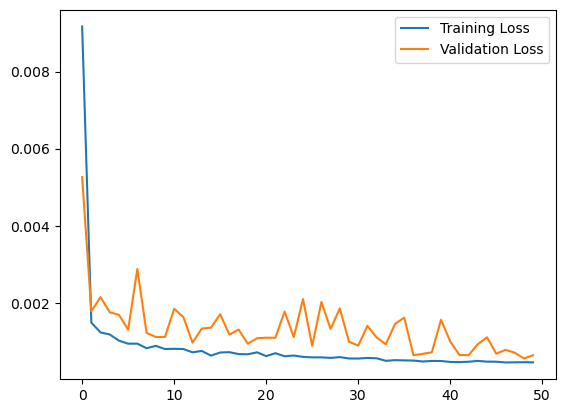

In [19]:
#Evaluating model loss
loss = best_model.evaluate(X_test, y_test)
print(f'Final loss: {loss}')

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


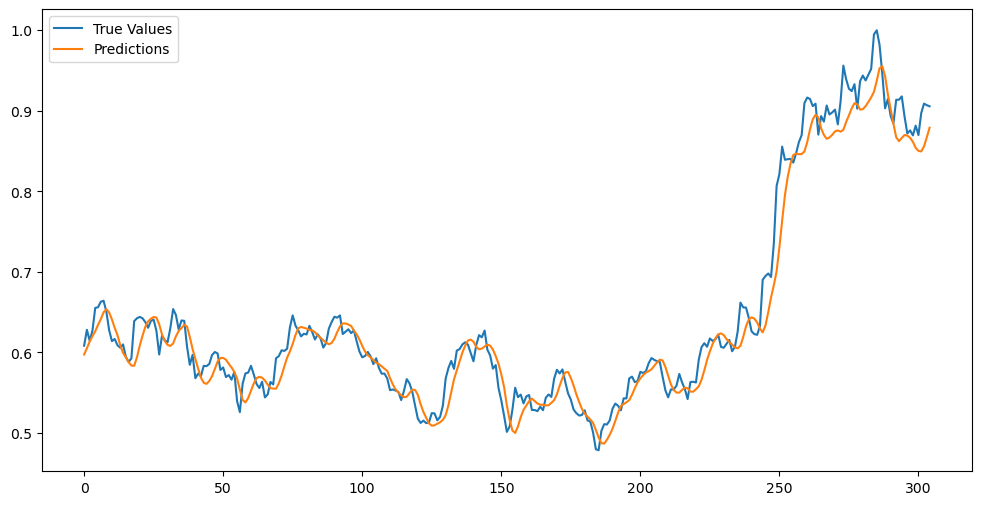

In [20]:
#Evaluate the Model predictions
predicted = best_model.predict(X_test)
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='True Values')
plt.plot(predicted, label='Predictions')
plt.legend()
plt.show()


In [21]:
#Save Optimization Data
optimization_data = pd.DataFrame({
    'Epoch': range(1, len(history.history['loss']) + 1),
    'Training Loss': history.history['loss'],
    'Validation Loss': history.history['val_loss']
})
optimization_data.to_csv('bitcoin_optimization_log.csv', index=False)


In [22]:
# # Display results
# print(f"RMSE: {rmse}")
# print(f"R^2 Score: {r2}")


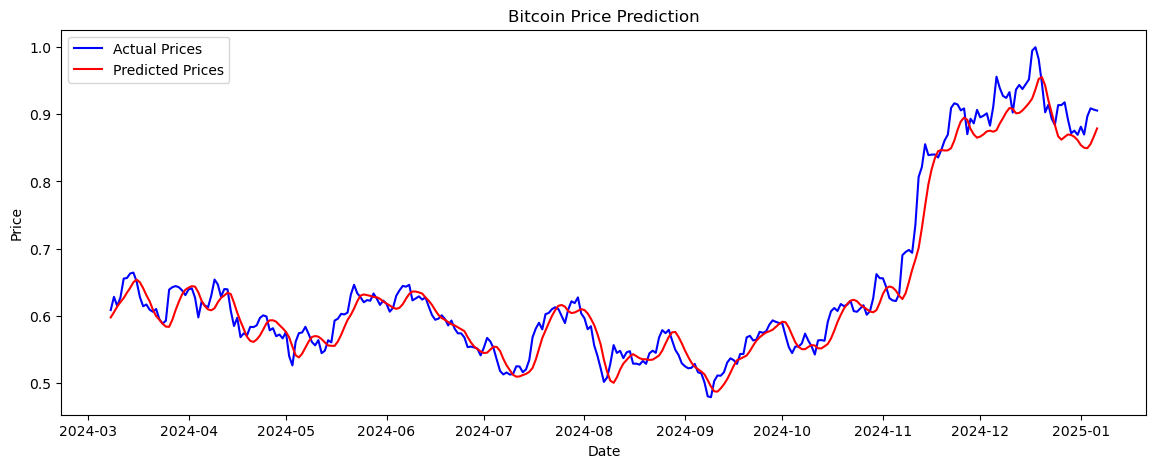

In [23]:
dates = data.index[-len(y_test):]
# Visualization
plt.figure(figsize=(14, 5))
plt.plot(dates, y_test, color='blue', label='Actual Prices')
plt.plot(dates, predicted, color='red', label='Predicted Prices')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


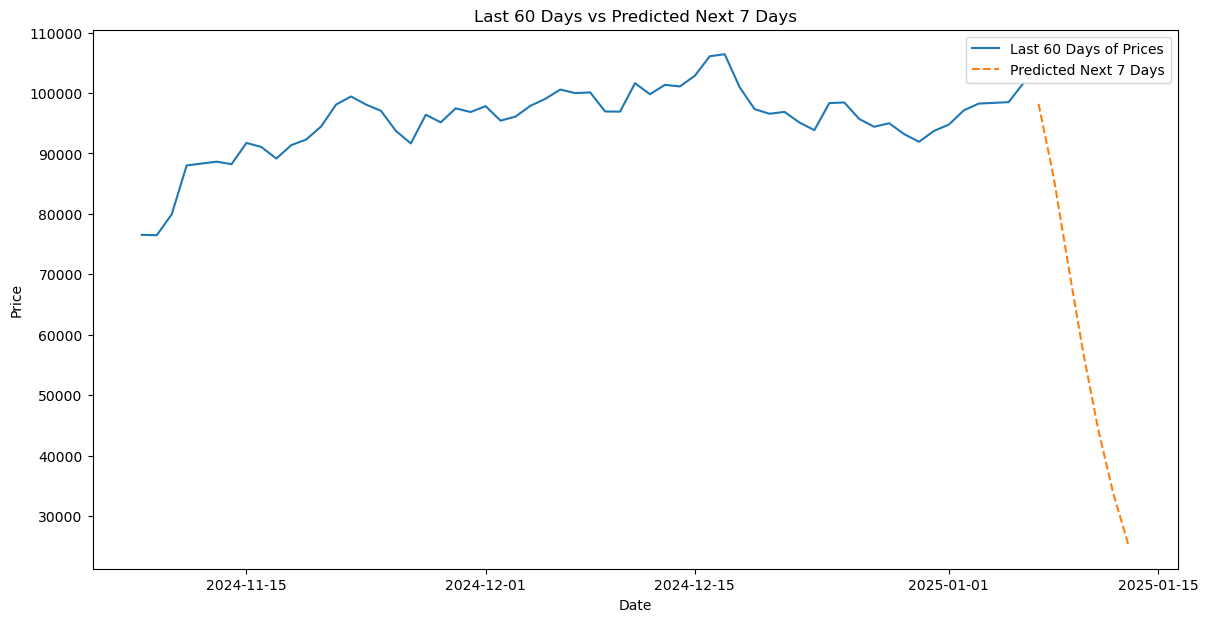

In [24]:
# Function to predict future prices
def predict_future_prices(best_model, last_data, n_future):
    future_prices = []
    current_input = last_data

    for _ in range(n_future):
        # Reshape input to be [samples, time steps, features]
        current_input = np.reshape(current_input, (1, current_input.shape[0], current_input.shape[1]))
        # Predict the next price
        predicted_price = best_model.predict(current_input)
        # Store the predicted price
        future_prices.append(predicted_price[0][0])
        # Update the input for the next prediction
        next_input = np.append(current_input[0, 1:], [[predicted_price[0][0], 0, 0]], axis=0)  # Append new price
        current_input = next_input

    return future_prices

# Predict future prices
n_future = 7  # Predict for the next 7 days
last_data = test_data[-time_step:]  # Last 60 days of test data
future_prices = predict_future_prices(best_model, last_data, n_future)

# Prepare the data for inverse transform
future_prices_full = np.zeros((len(future_prices), 3))
future_prices_full[:, 2] = future_prices  # Assign predictions to PX_LAST

# Inverse transform the predicted prices
future_prices = scaler.inverse_transform(future_prices_full)[:, 2]

# Prepare dates for plotting
last_date = data.index[-1]
future_dates = pd.date_range(start=last_date, periods=n_future + 1, freq='D')[1:]

# Plot last 60 days and future predictions
plt.figure(figsize=(14, 7))
plt.plot(data.index[-60:], data['PX_LAST'][-60:], label='Last 60 Days of Prices')
plt.plot(future_dates, future_prices, label='Predicted Next 7 Days', linestyle='--')
plt.legend()
plt.title('Last 60 Days vs Predicted Next 7 Days')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


In [25]:
# # Optionally, visualize the future prices along with the actual prices
# plt.figure(figsize=(14, 5))
# plt.plot(data.index, scaler.inverse_transform(values), color='blue', label='Actual Prices')
# plt.plot(future_prices_df.index, future_prices_df['Predicted Price'], color='orange', label='Future Prices')
# plt.title('Bitcoin Price Prediction and Future Forecast')
# plt.xlabel('Year')
# plt.ylabel('Price')
# plt.legend()
# plt.show()